In [2]:
# Time Series Prediction with LSTM
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
#convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 return numpy.array(dataX), numpy.array(dataY)

In [4]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [5]:
dataset_name = "q1"
product_name = "ch4"
file_path = 'dataset/'+dataset_name+'.csv'
dataframe = pd.read_csv(file_path)
print("Dataframe: \n", dataframe)
dataset = numpy.asarray(dataframe[product_name]).reshape(-1,1)
print("Dataset: \n", dataset)

Dataframe: 
             date dist        co       no2        o3  so2  ch4      hcho
0     2018-04-30   q1  0.036519  0.000059  0.127509  0.0    0  0.000000
1     2018-05-01   q1  0.035765  0.000053  0.128756  0.0    0  0.000000
2     2018-05-02   q1  0.037218  0.000051  0.127053  0.0    0  0.000000
3     2018-05-03   q1  0.000000  0.000000  0.120879  0.0    0  0.000000
4     2018-05-04   q1  0.000000  0.000000  0.121712  0.0    0  0.000000
...          ...  ...       ...       ...       ...  ...  ...       ...
1281  2021-11-01   q1  0.032100  0.000000  0.120907  0.0    0  0.000000
1282  2021-11-02   q1  0.000000  0.000239  0.115687  0.0    0  0.000239
1283  2021-11-03   q1  0.030268  0.000000  0.115781  0.0    0  0.000000
1284  2021-11-04   q1  0.028053  0.000200  0.116181  0.0    0  0.000200
1285  2021-11-05   q1  0.000000  0.000000  0.111895  0.0    0  0.000000

[1286 rows x 8 columns]
Dataset: 
 [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [6]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print("Dataset after scale: \n", dataset)

Dataset after scale: 
 [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [7]:
# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [8]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print("TrainX shape: ", trainX.shape)
print("TrainY shape: ", trainY.shape)

TrainX shape:  (1155, 1)
TrainY shape:  (1155,)


In [9]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [10]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(trainX, trainY, epochs=1000, batch_size=10, verbose=2,
          validation_data=(testX, testY))

score = model.evaluate(testX, testY, verbose=0)
print('score: test score = ', score[0], ' / accuracy = ', score[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
116/116 - 3s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/1000
116/116 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/1000
116/116 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/1000
116/116 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/1000
116/116 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss:

In [11]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [12]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

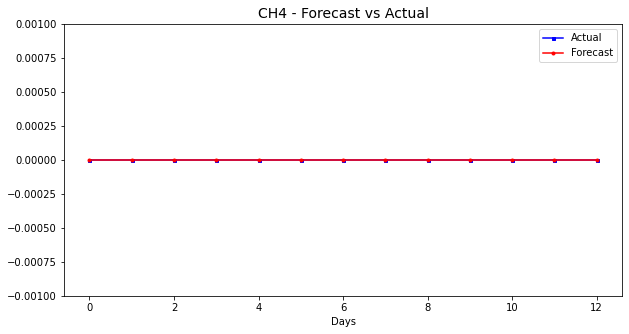

In [13]:
test_Y = testY[0][len(testY[0])-14:len(testY[0])-1]
test_Ypred = testPredict[len(testPredict)-14:len(testPredict)-1]
plt.subplots(figsize=(10, 5))
plt.title(product_name.upper() + " - Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(numpy.ravel(test_Y)), "bs-", markersize=3, label="Actual")
plt.plot(pd.Series(numpy.ravel(test_Ypred)), "ro-", markersize=3, label="Forecast")
plt.legend(loc="best")
plt.xlabel("Days")
plt.ylim([-0.001,0.001])
plt.show()

In [14]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.8f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.8f RMSE' % (testScore))

Train Score: 0.00000000 RMSE
Test Score: 0.00000000 RMSE


In [15]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [16]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

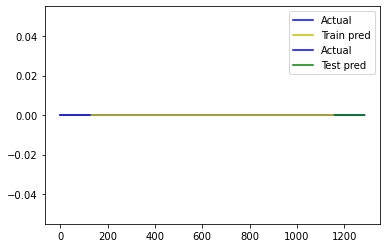

In [17]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset),"b-", label="Actual")
plt.plot(trainPredictPlot,"y-", label="Train pred")
plt.plot(scaler.inverse_transform(testY)[0],"b-", label="Actual")
plt.plot(testPredictPlot, "g-", label="Test pred")
plt.legend(loc="best")
plt.show()
